In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(y_train_inv, y_train_pred_inv):
    # Check if lengths of the actual and predicted RUL match
    if len(y_train_inv) != len(y_train_pred_inv):
        raise ValueError("The lengths of actual RUL and predicted RUL must be the same.")
    
    # Convert to numpy arrays if they are pandas Series or DataFrame
    y_train_inv = np.array(y_train_inv) if isinstance(y_train_inv, (pd.Series, pd.DataFrame)) else y_train_inv
    y_train_pred_inv = np.array(y_train_pred_inv) if isinstance(y_train_pred_inv, (pd.Series, pd.DataFrame)) else y_train_pred_inv

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the X-axis (assuming the length of y_train_inv is the number of samples)
    index = range(len(y_train_inv))  # Generate the index for the x-axis based on the number of samples

    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjust figure size if necessary
    plt.bar(index, y_train_inv, width=bar_width, label='Actual RUL', alpha=0.7)
    plt.bar([i + bar_width for i in index], y_train_pred_inv, width=bar_width, label='Predicted RUL', alpha=0.7)

    # Labeling the plot
    plt.xlabel('Sample Index')
    plt.ylabel('RUL')
    plt.title('Comparison of Actual vs Predicted RUL')

    # Limit the number of x-ticks to 10 by selecting 10 evenly spaced index positions
    num_ticks = 10
    tick_positions = np.linspace(0, len(index)-1, num_ticks, dtype=int)
    tick_labels = [str(i) for i in tick_positions]  # Create string labels for the x-ticks

    # Set the x-ticks
    plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for clarity
    
    plt.legend()

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()
def plot_result(y_actual, y_pred, first_label = 'actual', seconds_label = 'predicted'):
    plt.figure(figsize= (20, 5))
    plt.plot(y_actual, label=first_label, color = 'blue')
    plt.plot(y_pred, label= seconds_label, color='orange' )
    plt.legend()
    plt.show()

In [5]:
with open("../utils/columns.json", 'rb') as file:
    column_names = json.load(file)['trainTestColumns']

In [6]:
column=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [7]:
train=pd.read_csv("../data/train_FD001.txt",sep=" ",names=column)

In [8]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('engine')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['engine','max']
    df = df.merge(fd_RUL, on=['engine'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

In [9]:
test=pd.read_csv("../data/test_FD001.txt",sep=" ",names=column)
test_results=pd.read_csv("../data/RUL_FD001.txt",sep=" ",header=None)

test_results.columns=["rul","null"]
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

test_results['rul_failed']=test_results['rul']+rul['max']
test_results.drop(["rul"],axis=1,inplace=True)

test=test.merge(test_results,on=['id'],how='left')
test["RUL"]=test["rul_failed"]-test["cycle"]
test.drop(columns=['rul_failed'], inplace=True)

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
te_null_df = pd.DataFrame(test.isnull().sum()).T
te_null_df[te_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,13096,13096


In [12]:
tr_null_df = pd.DataFrame(train.isnull().sum()).T
tr_null_df[tr_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,20631,20631


In [13]:
null_cols = ["sensor22","sensor23"]

In [14]:
#Dropping null columns
df_train=train.drop(null_cols,axis=1)
df_train.columns = column_names
df_train = prepare_train_data(df_train)

df_test=test.drop(null_cols,axis=1)
df_test.columns = column_names+['RUL']

In [15]:
train_end = int(len(df_train)*0.9)

In [16]:
sensor_cols = [col for col in df_train.columns if col not in ['RUL', 'engine', 'cycle']]

In [17]:
uniq_val_col = []
for col in sensor_cols:
    if df_train[col].nunique() ==1:
        uniq_val_col.append(col)

In [18]:
uniq_val_col

['setting_3',
 'Fan_inlet_temperature_R',
 'Fan_inlet_Pressure_psia',
 'Engine_pressure_ratioP50_P2',
 'Burner_fuel_air_ratio',
 'Required_fan_speed',
 'Required_fan_conversion_speed']

In [19]:
sensor_cols = [col for col in sensor_cols if col not in uniq_val_col]

In [20]:
linear_corr = df_train[sensor_cols].corr(method='pearson')
nonlinear_corr_spearman = df_train.corr(method='spearman')

In [21]:
def high_corr_col(linear_corr):
    threshold = 0.85

    # Identify columns to drop based on Pearson correlation
    high_corr = np.where(abs(linear_corr) > threshold)
    high_corr_pairs = [(linear_corr.index[x], linear_corr.columns[y]) for x, y in zip(*high_corr) if x != y]

    # Track columns to drop, avoiding duplicates
    to_drop = set()
    for (col1, col2) in high_corr_pairs:
        to_drop.add(col1 if col1 not in to_drop else col2)

    print("Columns dropped:", to_drop)
    return list(to_drop)

In [22]:
lin_col_to_drop = high_corr_col(linear_corr)
non_lin_col_to_drop = high_corr_col(nonlinear_corr_spearman)

Columns dropped: {'Corrected_core_speed_rpm', 'Physical_core_speed_rpm'}
Columns dropped: {'Corrected_core_speed_rpm', 'Physical_core_speed_rpm'}


In [23]:
df_train.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)
df_test.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)

In [24]:
# plot_result(df_train[df_train.filter(like='temperature').columns[0]], df_train['RUL'])

In [25]:
exo_col = [col for col in df_train.columns if col not in ['RUL']] #[col for col in df_train.columns if col not in ['RUL', 'engine', 'cycle']] 
endo_col = ['RUL']

In [26]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train, y_train = scaler_x.fit_transform(df_train[exo_col][:train_end]), scaler_y.fit_transform(df_train[['RUL']][:train_end]) 
x_val, y_val  =  scaler_x.transform(df_train[exo_col][train_end:]), scaler_y.transform(df_train[['RUL']][train_end:])
x_test, y_test = scaler_x.transform(df_test[exo_col]), df_test[['RUL']].values

In [27]:
# with open("scaler_y.pkl", "wb") as file:
#     pickle.dump(scaler_y, file)
# with open("./scaler_x.pkl", "wb") as file:
#     pickle.dump(scaler_x, file)

In [28]:
# # Without scaling (Splitting train and val as we do it for scaling case)
# x_train, y_train = df_train[exo_col][:train_end].values, df_train[['RUL']][:train_end].values
# x_val, y_val  =  df_train[exo_col][train_end:].values, df_train[['RUL']][train_end:].values

# x_test, y_test = df_test[exo_col].values, df_test[['RUL']].values

In [29]:
def evaluate(y_true, y_pred):
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
    print(f'r2 score: {r2_score(y_true, y_pred):.2f}')
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask for non-zero actual values
    act_non_zero_mask = y_true != 0

    # Create a mask for non-zero pred values
    pred_non_zero_mask = y_pred != 0

    # Ensure that there are non-zero actual values
    if not np.any(act_non_zero_mask):
        raise ValueError("All actual values are zero, MAPE is undefined.")
    if not np.any(pred_non_zero_mask):
        raise ValueError("All pred values are zero, MAPE will be 100%.")

    # Calculate MAPE
    non_zero_mask = np.logical_and(act_non_zero_mask, pred_non_zero_mask)
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    # abs_percentage_error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(abs_percentage_error) * 100
    print(f'MAPE: {mape:.2f}')

ML models

XGBoost

In [ ]:
# Create the XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.01, max_depth=6, random_state=42) #best Subsample = 0.8,
# Train the model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Create the XGBoost regressor model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    learning_rate=0.01,
    max_depth=6,
    # subsample=0.8,  # Added best subsample parameter
    random_state=42
)

# Train the model
model.fit(x_train, y_train)

# Get feature importance
feature_importance = model.feature_importances_

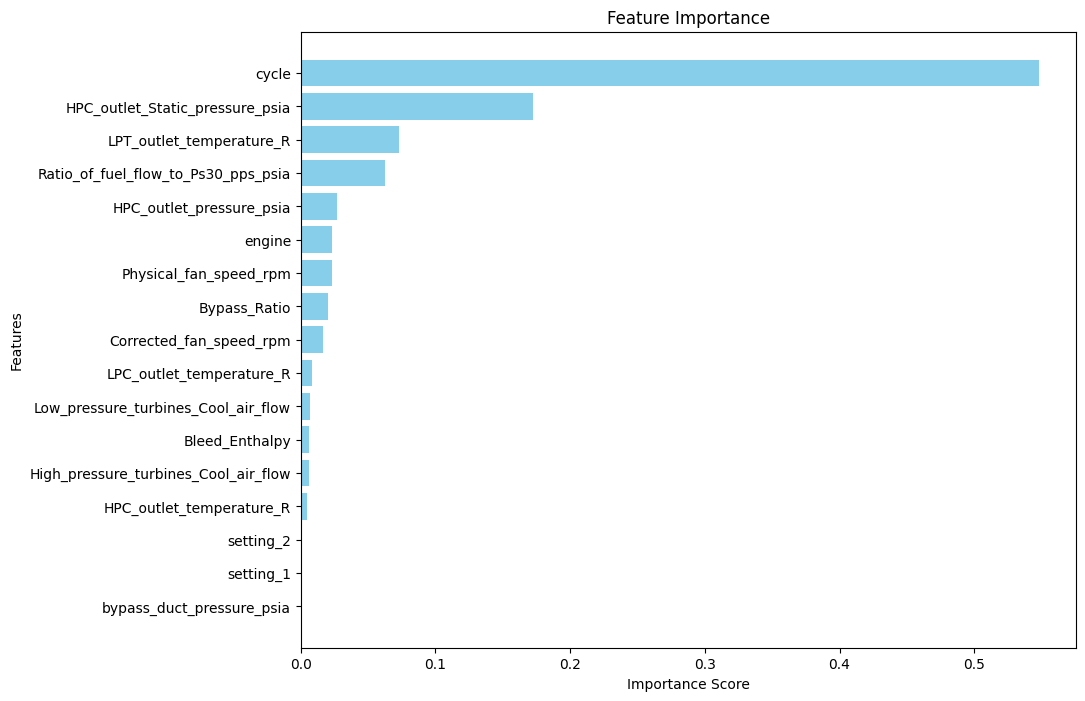

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance and map to feature names
feature_importance = model.feature_importances_
feature_names = exo_col

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot all features, including those with zero importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


************Train*********
RMSE: 30.21
MAE: 23.53
r2 score: 0.80
MAPE: 70.85


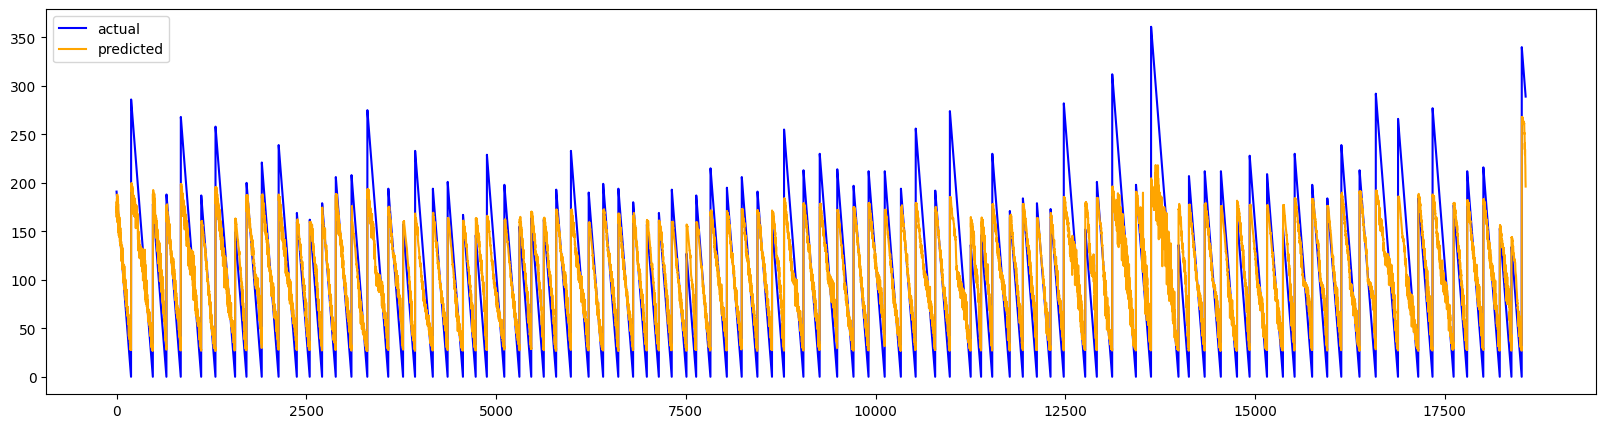

***************Test**********
RMSE: 47.68
MAE: 36.12
r2 score: 0.35
MAPE: 29.13


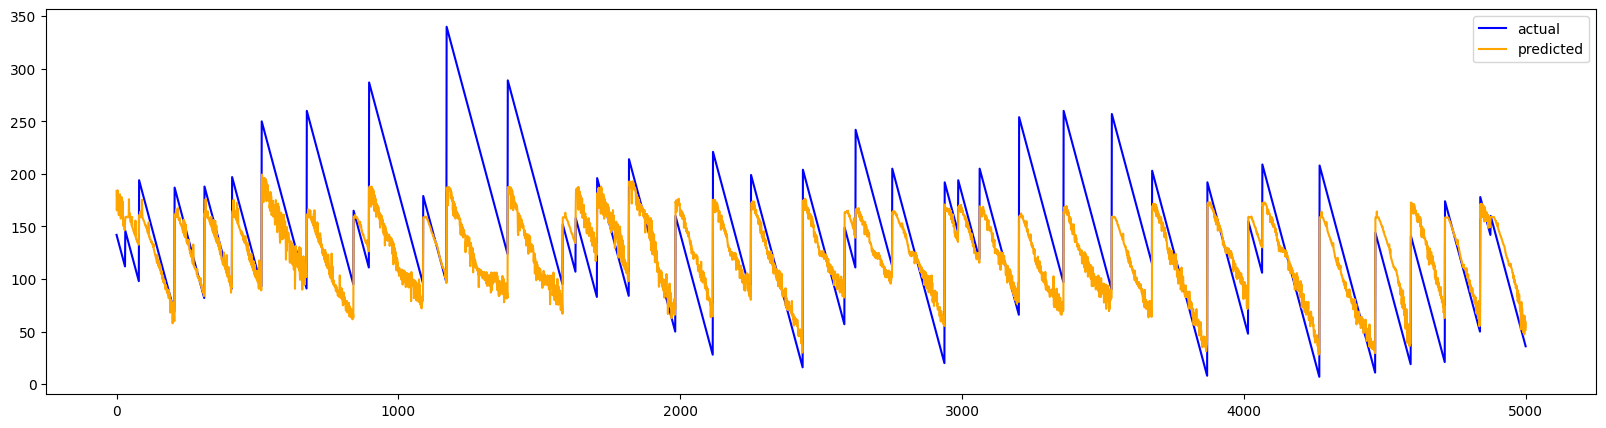

In [42]:
# 2. Evaluate the best model on the train data
y_pred_train = scaler_y.inverse_transform(model.predict(x_train).reshape(-1, 1))
y_train_inv = scaler_y.inverse_transform(y_train)
print("************Train*********")
evaluate(y_train_inv, y_pred_train)
plot_result(y_train_inv, y_pred_train)
print("***************Test**********")
y_pred_test_lin_reg = scaler_y.inverse_transform(model.predict(x_test).reshape(-1,1))
evaluate(y_test, y_pred_test_lin_reg)
plot_result(y_test[:5000], y_pred_test_lin_reg[:5000])

Train


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_16176\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


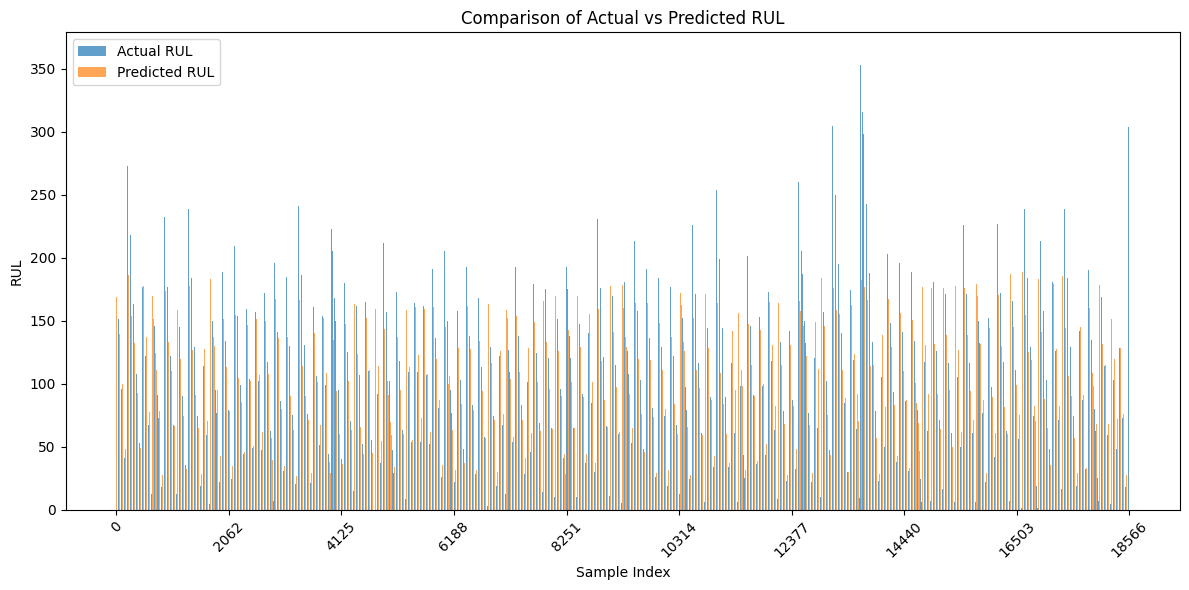

Test


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_16176\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


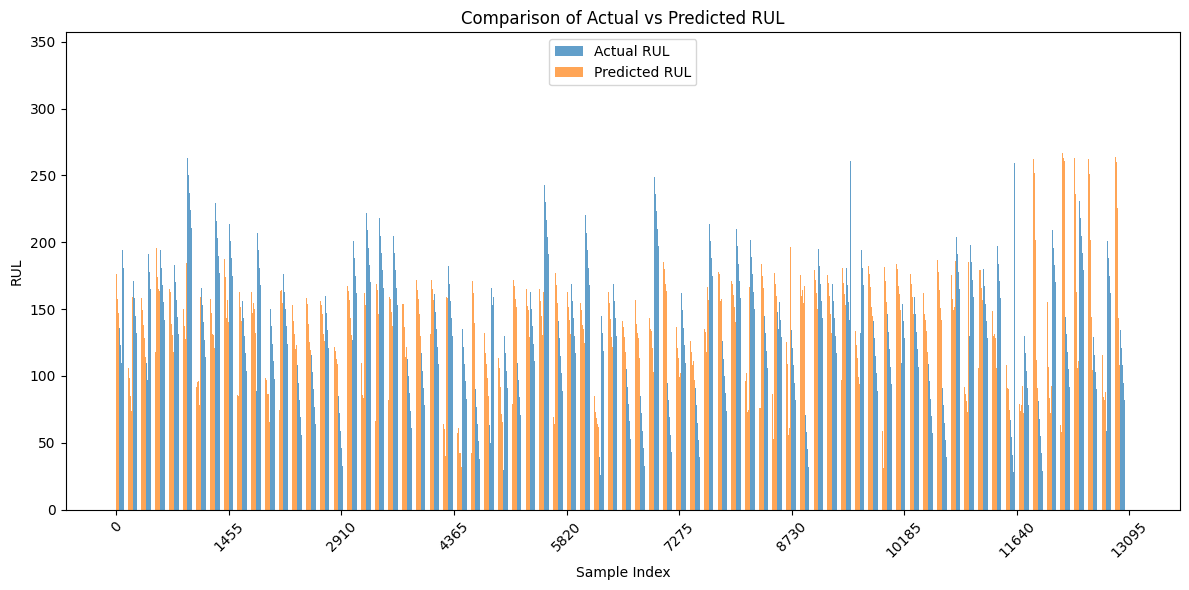

In [35]:
print("Train")
plot_bar(y_train_inv.squeeze(), y_pred_train.squeeze())
print("Test")
plot_bar(y_test.squeeze(), y_pred_test_lin_reg.squeeze())

Linear regression

In [45]:
from sklearn.linear_model import LinearRegression

# Train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

# Retrieve coefficients
coefficients = model_lr.coef_
feature_names = exo_col

                                 Feature  Importance
1                                  cycle    0.479590
0                                 engine    0.095025
10       HPC_outlet_Static_pressure_psia    0.090712
6               LPT_outlet_temperature_R    0.062203
11   Ratio_of_fuel_flow_to_Ps30_pps_psia    0.056421
13                          Bypass_Ratio    0.051135
16   Low_pressure_turbines_Cool_air_flow    0.047485
8               HPC_outlet_pressure_psia    0.046644
4               LPC_outlet_temperature_R    0.044280
15  High_pressure_turbines_Cool_air_flow    0.034561
14                        Bleed_Enthalpy    0.033135
5               HPC_outlet_temperature_R    0.030253
3                              setting_2    0.011485
12               Corrected_fan_speed_rpm    0.011186
7              bypass_duct_pressure_psia    0.010614
9                 Physical_fan_speed_rpm    0.005569
2                              setting_1    0.001222


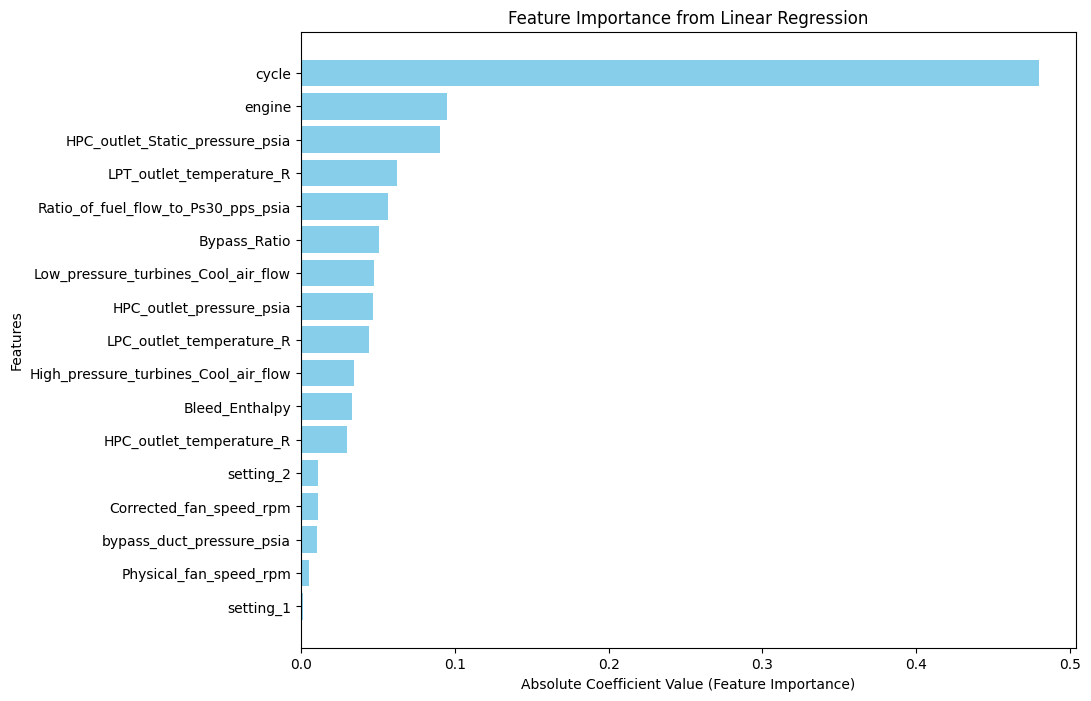

In [54]:
# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": np.abs(coefficients)[0]
}).sort_values(by="Importance", ascending=False)

# Display the feature importance
print(importance_df)
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Absolute Coefficient Value (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance from Linear Regression")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()

Train


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_16176\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


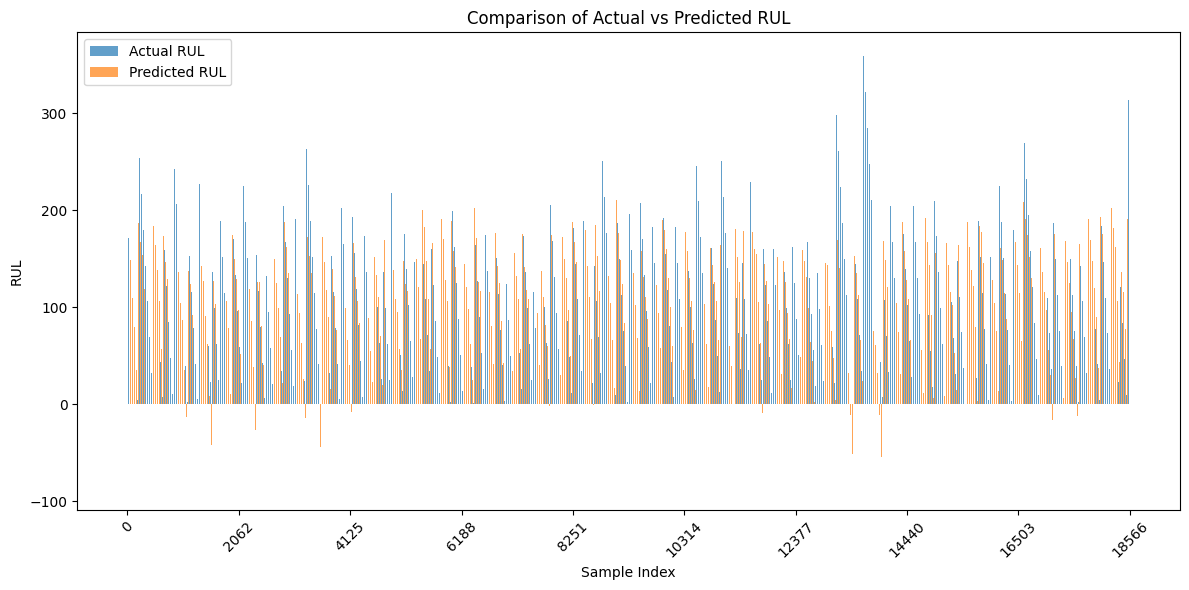

Test


C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_16176\2869075175.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent label overlap
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


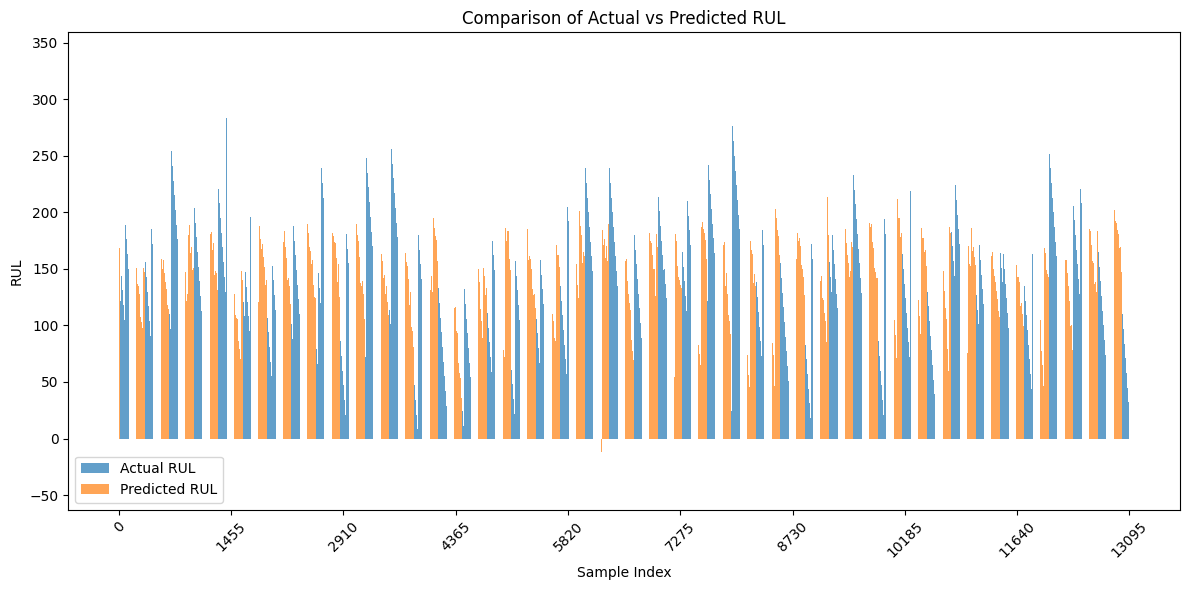

In [38]:
print("Train")
plot_bar(y_train_ori.squeeze(), y_pred_train_lin_reg.squeeze())

print("Test")
plot_bar(y_test.squeeze(), y_pred_test_lin_reg.squeeze())

*********Train************
RMSE: 37.55
MAE: 28.60
r2 score: 0.69
MAPE: 62.65


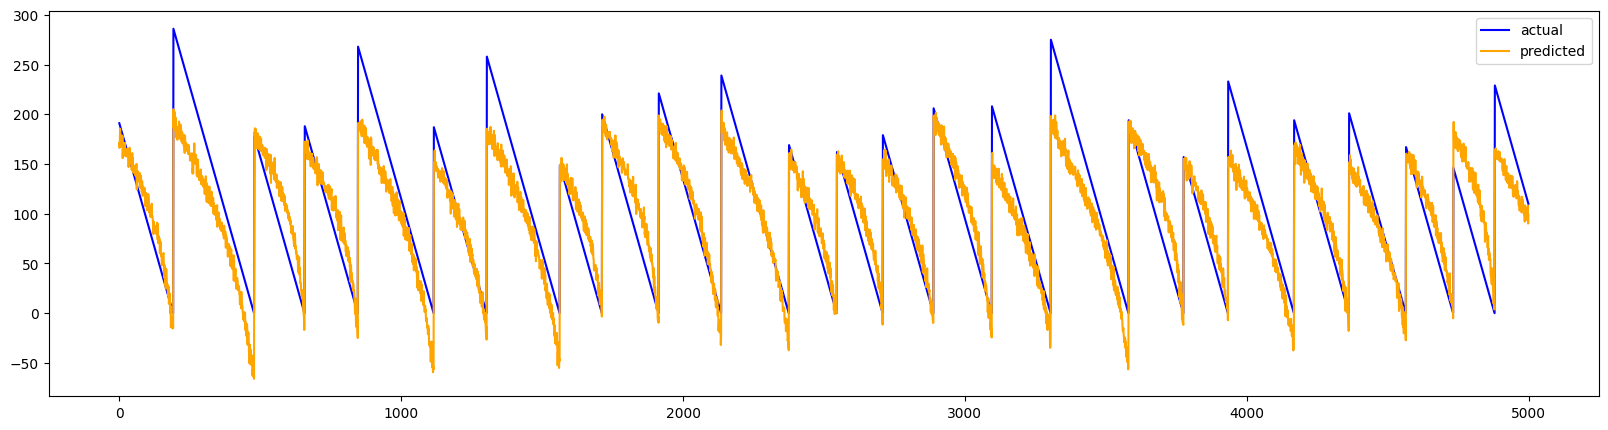

*********Test************
RMSE: 43.34
MAE: 33.89
r2 score: 0.46
MAPE: 29.61


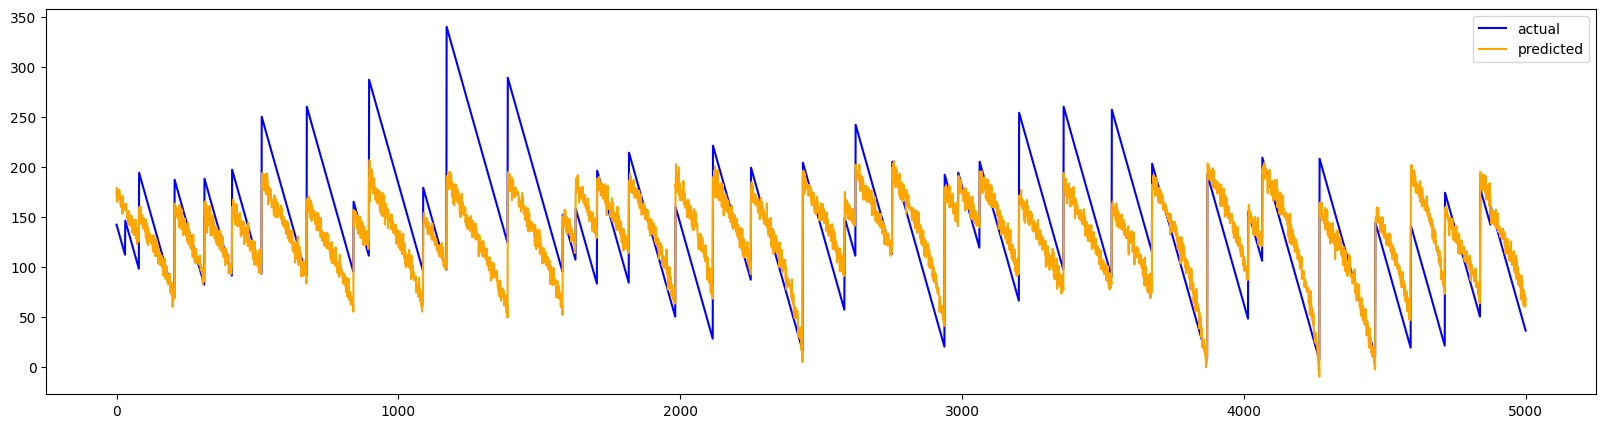

In [55]:
y_pred_train_lin_reg = scaler_y.inverse_transform(model_lr.predict(x_train))
y_train_ori = scaler_y.inverse_transform(y_train)
print("*********Train************")
evaluate(y_train_ori, y_pred_train_lin_reg)
plot_result(y_train_ori[:5000], y_pred_train_lin_reg[:5000])

y_pred_test_lin_reg = scaler_y.inverse_transform(model_lr.predict(x_test))
print("*********Test************")
evaluate(y_test, y_pred_test_lin_reg)
plot_result(y_test[:5000], y_pred_test_lin_reg[:5000])

*********Train************
RMSE: 37.55
MAE: 28.60
r2 score: 0.69
MAPE: 62.65


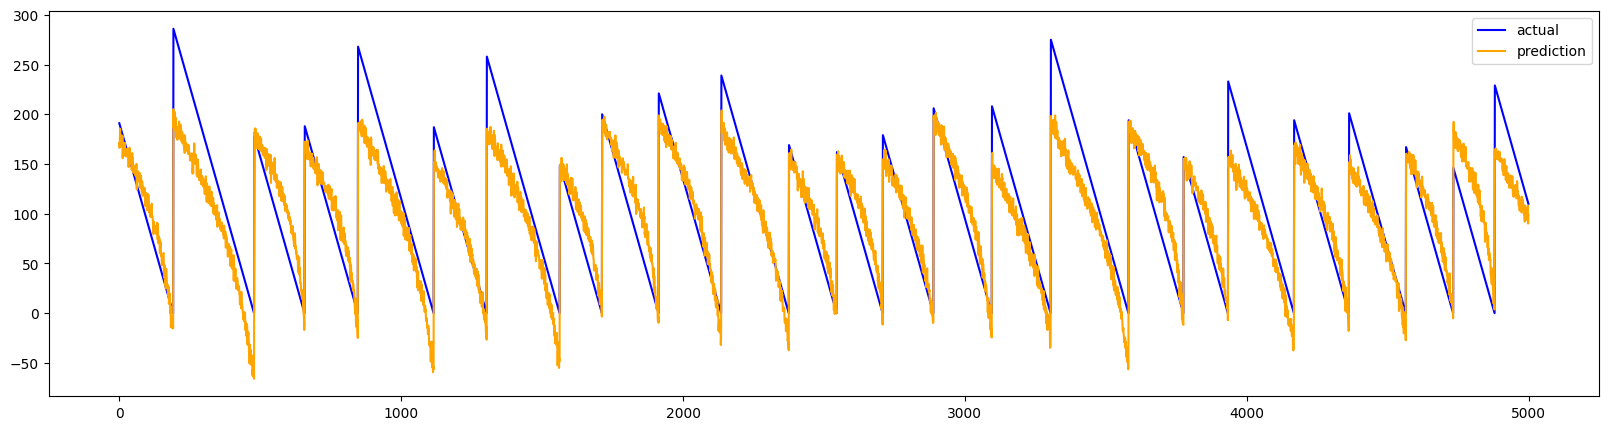

*********Test************
RMSE: 43.34
MAE: 33.89
r2 score: 0.46
MAPE: 29.61


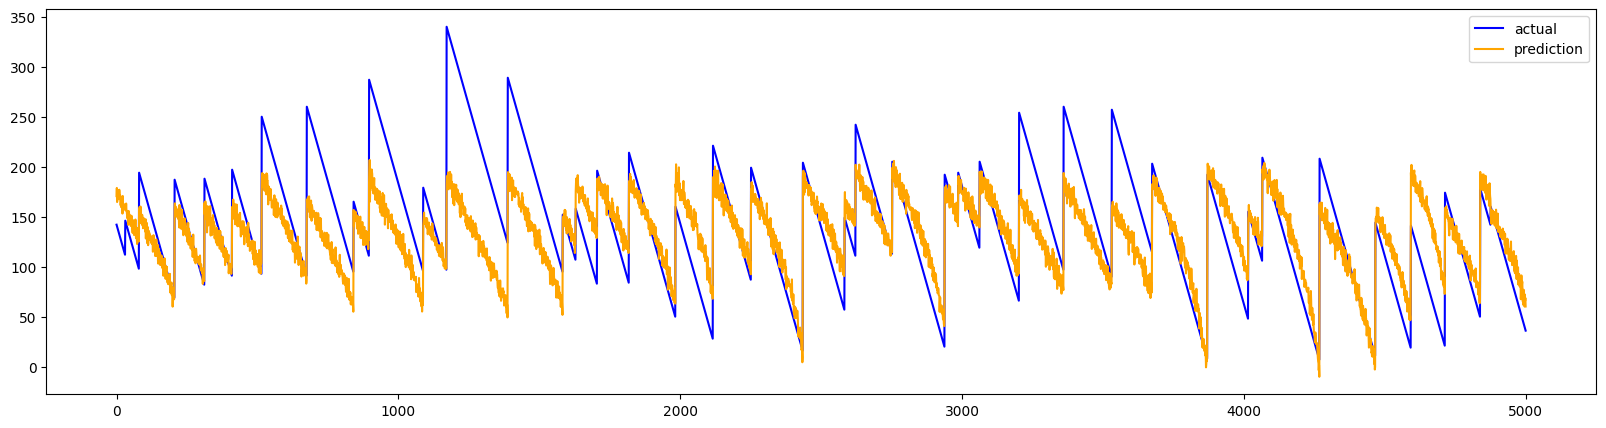

In [30]:
y_pred_train_lin_reg = scaler_y.inverse_transform(model_lr.predict(x_train))
y_train_ori = scaler_y.inverse_transform(y_train)
print("*********Train************")
evaluate(y_train_ori, y_pred_train_lin_reg)
plot_result(y_train_ori[:5000], y_pred_train_lin_reg[:5000])

y_pred_test_lin_reg = scaler_y.inverse_transform(model_lr.predict(x_test))
print("*********Test************")
evaluate(y_test, y_pred_test_lin_reg)
plot_result(y_test[:5000], y_pred_test_lin_reg[:5000])